In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split


start = time.time()

Matplotlib is building the font cache; this may take a moment.


In [2]:

dim = (224,224)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 50                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

# k_folds = 10                # number of folds for k-fold validation                              #k-folds someday

val20_epochs50


Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

In [7]:

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="E:\\Data set\\train",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="E:\\Data set\\test",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 145 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [8]:

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [9]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(177, 224, 224, 3)
(177, 2)


In [10]:

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (123, 224, 224, 3)
validation (18, 224, 224, 3)
test (36, 224, 224, 3)


In [11]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(123, 224, 224, 3)
(123, 2)
(18, 224, 224, 3)
(18, 2)
(36, 224, 224, 3)
(36, 2)


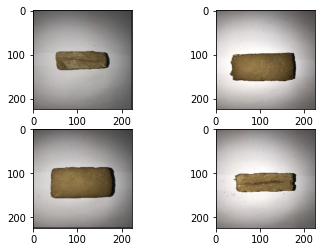

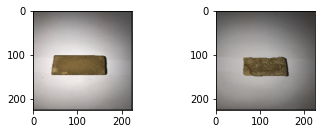

In [13]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[6,:,:,:])

In [14]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


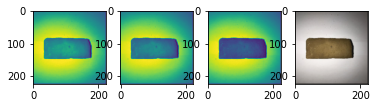

In [15]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [16]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.VGG19( weights="imagenet",include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

80142336/80134624 [==============================] - 29s 0us/step


In [17]:
## CHANGE MODEL STRUCTURE ##
#vg_model.trainable = False
# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
# vg_model.get_layer('block1_conv1').trainable = layers_unlocked
# vg_model.get_layer('block1_conv2').trainable = layers_unlocked
# vg_model.get_layer('block2_conv1').trainable = layers_unlocked
# vg_model.get_layer('block2_conv2').trainable = layers_unlocked
# vg_model.get_layer('block3_conv1').trainable = layers_unlocked
# vg_model.get_layer('block3_conv2').trainable = layers_unlocked
# vg_model.get_layer('block3_conv3').trainable = layers_unlocked
# vg_model.get_layer('block4_conv1').trainable = layers_unlocked
# vg_model.get_layer('block4_conv2').trainable = layers_unlocked
# vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(2,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [18]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [19]:
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/50
7/7 [==============================] - 68s 10s/step - loss: 0.7923 - accuracy: 0.5854 - val_loss: 0.4789 - val_accuracy: 0.8333
Epoch 2/50
7/7 [==============================] - 70s 10s/step - loss: 0.4975 - accuracy: 0.7642 - val_loss: 0.3049 - val_accuracy: 0.8889
Epoch 3/50
7/7 [==============================] - 71s 10s/step - loss: 0.2585 - accuracy: 0.9593 - val_loss: 0.1893 - val_accuracy: 0.9444
Epoch 4/50
7/7 [==============================] - 71s 10s/step - loss: 0.1621 - accuracy: 0.9675 - val_loss: 0.1305 - val_accuracy: 0.9444
Epoch 5/50
7/7 [==============================] - 72s 10s/step - loss: 0.0830 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9444
Epoch 6/50
7/7 [==============================] - 74s 11s/step - loss: 0.0487 - accuracy: 0.9919 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 92s 13s/step - loss: 0.0404 - accuracy: 0.9919 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 8/50
7/7 [===========

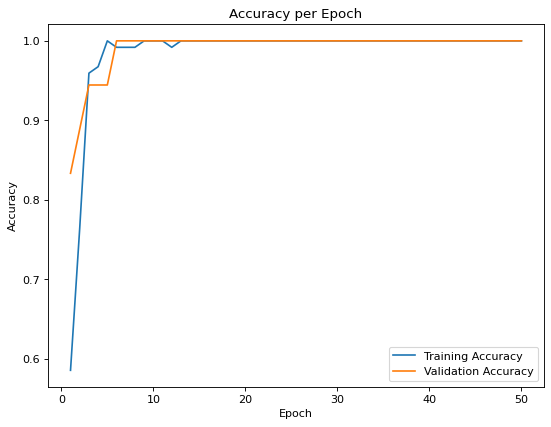

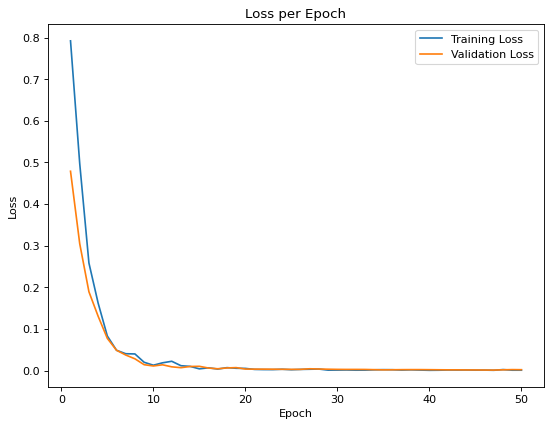

image dimensions:  (224, 224)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  50
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 155 minutes


In [20]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# print(np.amax.model_history.history['val_acc'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

In [21]:
vg_model.save('E:\\Data set\\Vgg19FSStandDim.h5')

In [22]:
# import pre-trained VGG16 model

vg_model = load_model("E:\\Data set\\Vgg19FSStandDim.h5") 

In [23]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

2/2 [==============================] - 1s 368ms/step - loss: 0.0063 - accuracy: 1.0000
Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Test Accuracy: 100.00%


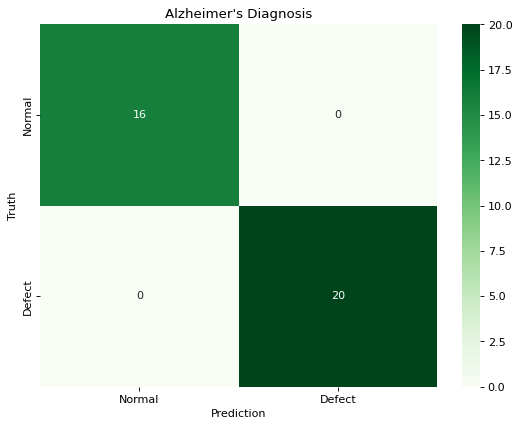

In [25]:

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap="Greens", annot=True, fmt='d', xticklabels= ['Normal', 'Defect'],
                yticklabels=['Normal', 'Defect'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)

In [26]:
print(classification_report(labels, predic, target_names=['Normal', 'Defect']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        16
      Defect       1.00      1.00      1.00        20

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



# FROM HERE TEST CODE STARTS

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv
from PIL import Image
import serial
import time


import matplotlib.pyplot as plt
arduino = serial.Serial(port='COM6', baudrate=115200, timeout=.1)
width = 224
height = 224
model = tf.keras.models.load_model('E:\\Data set\\Vgg19FSStandDim.h5')
video_capture = cv.VideoCapture(1)
def write_ard(x):
    arduino.write(bytes(x, 'utf-8'))
    time.sleep(0.05)



while True:
    # Capture frame-by-frame
    num = input("Enter anything: ")
    re,frame = video_capture.read()
    


    #Resize to respect the input_shape
    inp = cv.resize(frame, (width , height ))

    #Convert img to RGB
    rgb = cv.cvtColor(inp, cv.COLOR_BGR2RGB)
    plt.imshow(inp)
    plt.show()
    #Is optional but i recommend (float convertion and convert img to tensor image)
    rgb_tensor = tf.convert_to_tensor(rgb, dtype=tf.float32)
    
    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor , 0)

    #Now you can use rgb_tensor to predict label for exemple :
    
    #Load pretrain model, made from: https://www.tensorflow.org/tutorials/images/cnn
    
    
    #Predict label
    predictions = model.predict(rgb_tensor, steps=1)
    np.argmax(predictions)
    write_ard(num)
    

In [2]:
import cv2
import numpy as np

all_camera_idx_available = []

for camera_idx in range(10):
    cap = cv2.VideoCapture(camera_idx)
    if cap.isOpened():
        print(f'Camera index available: {camera_idx}')
        all_camera_idx_available.append(camera_idx)
        cap.release()

Camera index available: 0
Camera index available: 1
